In [1]:
!pip install tf-keras transformers tensorflow statsmodels seaborn scikit-learn > null

In [2]:
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
articles_name = 'green_energy_articles_max_articles_end20220101'
articles_df = pd.read_csv(f'datasets/{articles_name}.csv')
articles_df['Time'] = pd.to_datetime(articles_df['Time'], format='%d %b, %Y, %I:%M %p IST')
# Convert the 'Time' column in articles_df to datetime
articles_df['Date'] = pd.to_datetime(articles_df['Time'], format='%d %b, %Y, %I:%M %p IST').dt.date


print(f'Number of articles: {articles_df.shape[0]}')
articles_df.head()

Number of articles: 1254


,Title,Link,Description,Time,Date
0,"NexGen Energia plans to invest Rs 15,000 cr ov...",https://economictimes.indiatimes.com/industry/...,"NexGen Energia plans a Rs 15,000 crore investm...",2024-07-07 13:52:00,2024-07-07
1,JSW Energy plans ₹1.15 L cr capex to diversify...,https://economictimes.indiatimes.com/industry/...,JSW Energy announces a strategic shift towards...,2024-07-06 00:35:00,2024-07-06
2,Interest subvention likely to push energy effi...,https://economictimes.indiatimes.com/industry/...,The power ministry has begun discussions on of...,2024-07-05 23:45:00,2024-07-05
3,MNRE issues incentive guidelines for green hyd...,https://economictimes.indiatimes.com/industry/...,Solar Energy Corporation of India (SECI) is th...,2024-07-05 17:29:00,2024-07-05
4,Norms issued for funding of testing facilities...,https://economictimes.indiatimes.com/industry/...,The Ministry of New and Renewable Energy has r...,2024-07-05 00:41:00,2024-07-05


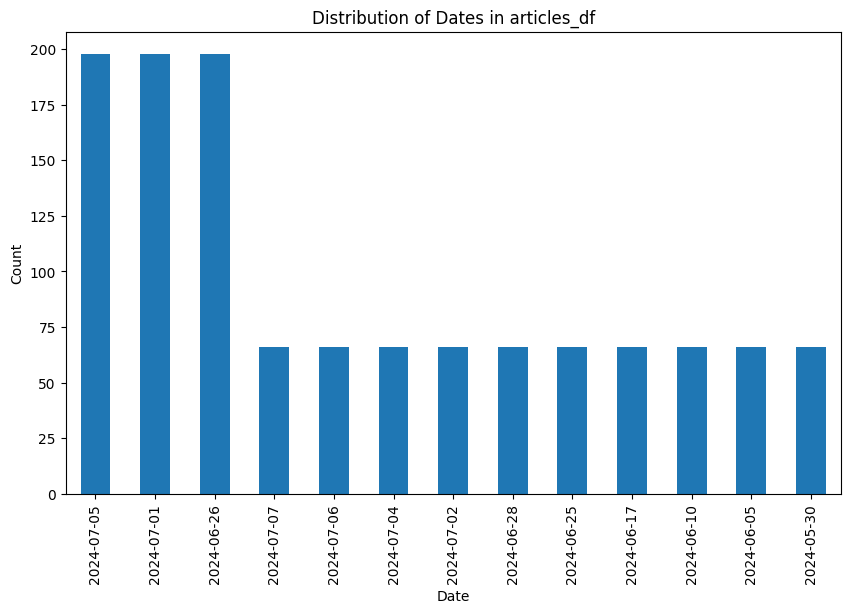

In [4]:
import matplotlib.pyplot as plt

# Count the occurrences of each date
date_counts = articles_df['Date'].value_counts()

# Plot the distribution of dates
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Dates in articles_df')
plt.show()

## Stock Data

In [16]:
product_name = 'ICLN'
prices_df = pd.read_csv(f'datasets/{product_name}.csv')

print(f'Number of rows: {prices_df.shape[0]}')
print(f'Missing values: {prices_df["Close"].isnull().sum()}')


# Convert the 'Date' column in prices_df to datetime
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date


# Set 'Date' as the index
prices_df.set_index('Date', inplace=True)

# Reindex to business days to fill missing dates
business_days = pd.bdate_range(start=prices_df.index.min(), end=prices_df.index.max())
prices_df = prices_df.reindex(business_days)

# Fill missing values (e.g., forward fill)
prices_df = prices_df.ffill()

# Calculate the daily price difference
prices_df['Close_diff'] = prices_df['Close'].diff()

print(f'first date: {prices_df.index.min()}')
print(f'last date: {prices_df.index.max()}')

prices_df.tail()

Number of rows: 4035
Missing values: 0
first date: 2008-06-25 00:00:00
last date: 2024-07-08 00:00:00


,Open,High,Low,Close,Adj Close,Volume,Close_diff
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,-0.05
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,0.33
2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,0.00
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,0.02
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,0.09


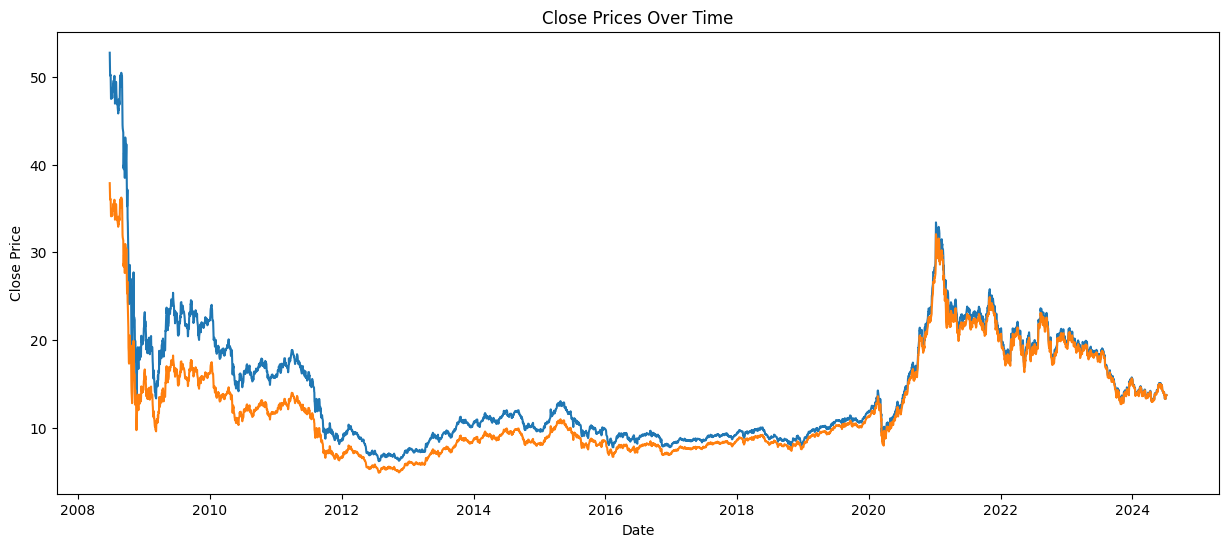

In [13]:
# Plot the 'Close' column
plt.figure(figsize=(15, 6))
sns.lineplot(data=prices_df, x=prices_df.index, y='Close')
sns.lineplot(data=prices_df, x=prices_df.index, y='Adj Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.show()


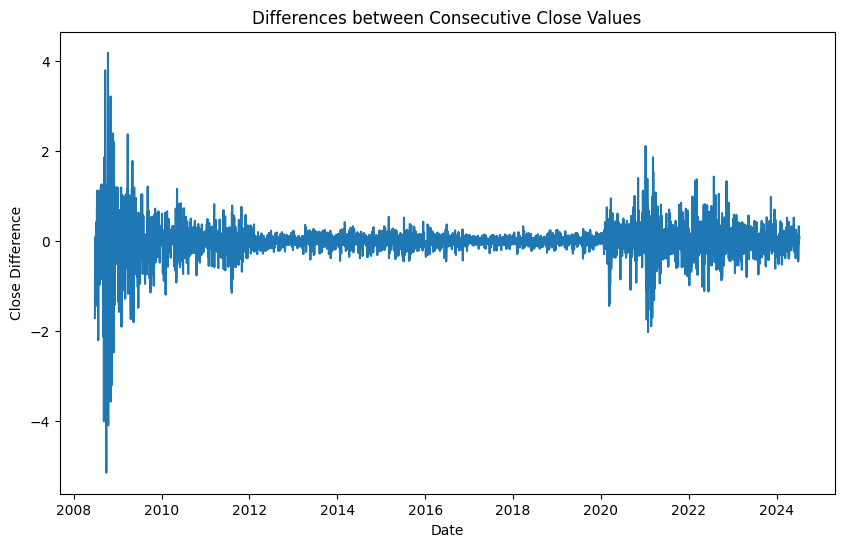

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(prices_df.index, prices_df['Close'].diff())
plt.xlabel('Date')
plt.ylabel('Close Difference')
plt.title('Differences between Consecutive Close Values')
plt.show()

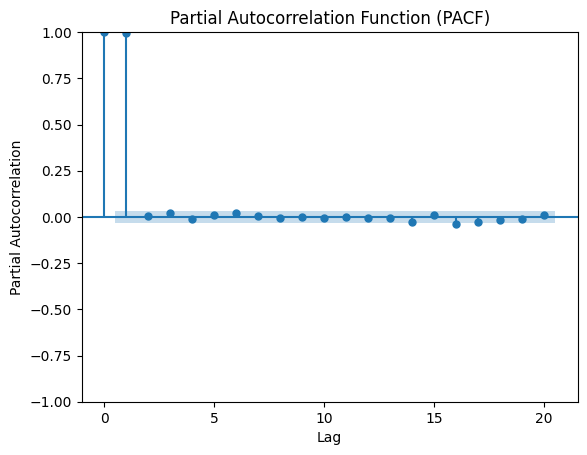

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf, acf

# Calculate PACF
pacf_scores = acf(prices_df['Close'], nlags=20)

# Plot PACF
plot_pacf(prices_df['Close'], lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# # Print PACF scores
# print("PACF Scores:")
# for lag, score in enumerate(pacf_scores):
#     print(f"Lag {lag}: {score}")

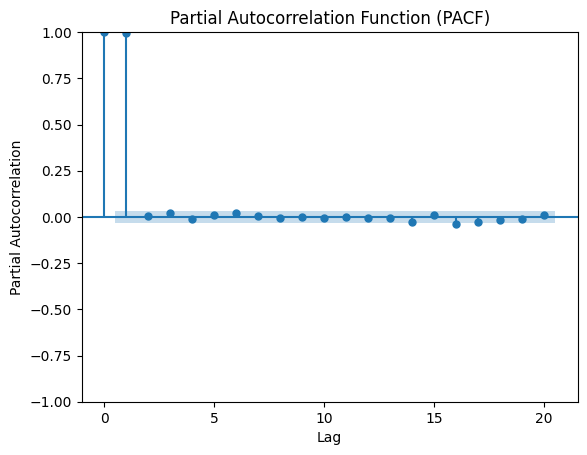

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

# Calculate PACF
pacf_scores = pacf(prices_df['Close'], nlags=20)

# Plot PACF
plot_pacf(prices_df['Close'], lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# # Print PACF scores
# print("PACF Scores:")
# for lag, score in enumerate(pacf_scores):
#     print(f"Lag {lag}: {score}")

We can see that Lag 1 prices are the most correlated with the current price

## Additional Features

In [53]:
#Lagged Features
# Create lag columns for 'Close', 'Open', 'High', 'Low'
prices_df['Close_Lag1'] = prices_df['Close'].shift(1)
prices_df['Open_Lag1'] = prices_df['Open'].shift(1)
prices_df['High_Lag1'] = prices_df['High'].shift(1)
prices_df['Low_Lag1'] = prices_df['Low'].shift(1)

# Technical Indicators
# Moving Averages
prices_df['SMA_5'] = prices_df['Close'].rolling(window=5).mean()
prices_df['SMA_10'] = prices_df['Close'].rolling(window=10).mean()

# Relative Strength Index (RSI)
def compute_rsi(data, window):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
prices_df['RSI_14'] = compute_rsi(prices_df['Close'], 14)

# Bollinger Bands
prices_df['BB_middle'] = prices_df['Close'].rolling(window=20).mean()
prices_df['BB_std'] = prices_df['Close'].rolling(window=20).std()
prices_df['BB_upper'] = prices_df['BB_middle'] + (prices_df['BB_std'] * 2)
prices_df['BB_lower'] = prices_df['BB_middle'] - (prices_df['BB_std'] * 2)

# Momentum
prices_df['MOM_10'] = prices_df['Close'].diff(10)


## Merge stocks and articles


In [54]:
# Reset the index to ensure 'Date' is a column
prices_df.reset_index(inplace=True)
prices_df.rename(columns={'index': 'Date'}, inplace=True)
# Convert the 'Date' column in prices_df to datetime and extract only the date part
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
prices_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10
4179,2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,13.29,13.474,13.721,10.731707,14.1680,0.555580,15.279161,13.056839,-0.88
4180,2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,13.18,13.450,13.666,25.229358,14.0945,0.527910,15.150320,13.038680,-0.55
4181,2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,13.59,13.36,13.64,13.34,13.414,13.630,29.729730,14.0285,0.502491,15.033483,13.023517,-0.36
4182,2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,13.34,13.472,13.600,34.545455,13.9825,0.496237,14.974974,12.990026,-0.30
4183,2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,13.53,13.550,13.565,37.209302,13.9285,0.462502,14.853504,13.003496,-0.35


In [59]:
# Ensure both are of datetime type
prices_df['Date'][0], articles_df['Date'][0]

(datetime.date(2008, 6, 25), datetime.date(2024, 7, 7))

In [117]:
# Merge articles with prices_df on date
merged_df = pd.merge(prices_df, articles_df, on='Date', how='left')

# Aggregate articles by date
aggregated_articles = merged_df.groupby('Date').agg({
    'Title': lambda x: ' '.join(x.dropna()),
    'Description': lambda x: ' '.join(x.dropna())
}).reset_index()

# Merge aggregated articles back with prices_df
final_df = pd.merge(prices_df, aggregated_articles, on='Date', how='left')
final_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,...,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10,Title,Description
4160,2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,...,13.474,13.721,10.731707,14.1680,0.555580,15.279161,13.056839,-0.88,World’s most volatile big stock is rocking Ind...,Indonesia's stock market faces turmoil as PT B...
4161,2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,...,13.450,13.666,25.229358,14.0945,0.527910,15.150320,13.038680,-0.55,,
4162,2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,13.59,13.36,13.64,...,13.414,13.630,29.729730,14.0285,0.502491,15.033483,13.023517,-0.36,India's solar output grows at slowest pace in ...,Solar power generation in the third-largest pr...
4163,2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,...,13.472,13.600,34.545455,13.9825,0.496237,14.974974,12.990026,-0.30,Interest subvention likely to push energy effi...,The power ministry has begun discussions on of...
4164,2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,...,13.550,13.565,37.209302,13.9285,0.462502,14.853504,13.003496,-0.35,,


## Extract Features from the Text


In [118]:
# Fill missing text data with an empty string
final_df['Title'] = final_df['Title'].fillna('')
final_df['Description'] = final_df['Description'].fillna('')

# Combine Title and Description into one text feature
final_df['Text'] = final_df['Title'] + ' ' + final_df['Description']
final_df = final_df.drop(columns=['Title', 'Description'])  # Drop individual text columns if not needed
final_df

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10,Text
0,2008-07-22,50.470001,51.799999,48.900002,49.200001,35.326126,9500.0,50.130001,49.750000,50.150002,49.520000,49.522000,48.910,62.444788,49.027000,1.380005,51.787009,46.266990,1.250000,
1,2008-07-23,49.610001,49.639999,49.119999,49.160000,35.297413,5000.0,49.200001,50.470001,51.799999,48.900002,49.454000,49.066,62.079071,48.846500,1.064743,50.975986,46.717013,1.560002,
2,2008-07-24,48.529999,48.529999,46.650002,46.959999,33.717789,6500.0,49.160000,49.610001,49.639999,49.119999,48.926000,48.960,46.954603,48.641499,1.009395,50.660289,46.622710,-1.060001,
3,2008-07-25,47.270000,47.509998,46.810001,47.509998,34.112686,2700.0,46.959999,48.529999,48.529999,46.650002,48.592000,48.885,47.764450,48.508999,0.972842,50.454683,46.563316,-0.750000,
4,2008-07-28,46.759998,47.529999,46.759998,47.209999,33.897285,18800.0,47.509998,47.270000,47.509998,46.810001,48.007999,48.683,46.080498,48.356999,0.922703,50.202406,46.511593,-2.020001,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,2024-07-02,13.260000,13.420000,13.180000,13.260000,13.260000,2154900.0,13.310000,13.400000,13.490000,13.290000,13.474000,13.721,10.731707,14.168000,0.555580,15.279161,13.056839,-0.880000,World’s most volatile big stock is rocking Ind...
4161,2024-07-03,13.360000,13.640000,13.340000,13.590000,13.590000,4990500.0,13.260000,13.260000,13.420000,13.180000,13.450000,13.666,25.229358,14.094500,0.527910,15.150320,13.038680,-0.550000,
4162,2024-07-04,13.360000,13.640000,13.340000,13.590000,13.590000,4990500.0,13.590000,13.360000,13.640000,13.340000,13.414000,13.630,29.729730,14.028500,0.502491,15.033483,13.023517,-0.360000,India's solar output grows at slowest pace in ...
4163,2024-07-05,13.560000,13.730000,13.530000,13.610000,13.610000,2619900.0,13.590000,13.360000,13.640000,13.340000,13.472000,13.600,34.545455,13.982500,0.496237,14.974974,12.990026,-0.300000,Interest subvention likely to push energy effi...


In [119]:
import os
from multiprocessing import Pool
import gc

embeddings_path = f'embeddings/bert_{product_name}_{articles_name}_embeddings.npy'
if not os.path.exists(os.path.dirname(embeddings_path)):
    os.makedirs(os.path.dirname(embeddings_path))

# Tokenize the text data
def encode_texts(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',  # Updated padding argument
            truncation=True,  # Added truncation argument
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

def get_bert_embeddings_in_batches(input_ids, attention_masks, bert_model, batch_size=16):
    all_embeddings = []
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_masks = attention_masks[i:i+batch_size]
        batch_embeddings = bert_model(batch_input_ids, attention_mask=batch_attention_masks)[0][:, 0, :].numpy()
        all_embeddings.append(batch_embeddings)
    return np.vstack(all_embeddings)

if os.path.exists(embeddings_path):
    # Load embeddings from file
    embeddings = np.load(embeddings_path)
    print(f'Loaded embeddings from: {embeddings_path}')
else:
    # Clear TensorFlow session to release GPU memory
    tf.keras.backend.clear_session()

    # Load BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    
    # Encode texts
    input_ids, attention_masks = encode_texts(final_df['Text'], tokenizer, max_length=128)

    embeddings = get_bert_embeddings_in_batches(input_ids, attention_masks, bert_model, batch_size=16)

    # Save embeddings to file
    np.save(embeddings_path, embeddings)
    
    # Clean up to release memory
    del input_ids
    del attention_masks
    del bert_model
    del tokenizer
    gc.collect()
    tf.keras.backend.clear_session()

Loaded embeddings from: embeddings/bert_ICLN_green_energy_articles_max_articles_end20220101_embeddings.npy


## Prepare the Dataset

In [120]:
# Create the target variable
final_df['Target'] = (final_df['Close'].shift(-1) > final_df['Close']).astype(int)

# Drop the 'Date' and 'Text' columns before scaling
X = final_df.drop(columns=['Date', 'Text', 'Target'])
X = np.hstack((X.values, embeddings))  # Combine numerical features with text embeddings
y = final_df['Target']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4165 and the array at index 1 has size 4184

In [104]:
# Check for NaN values in the scaled data
nan_mask = np.isnan(X_scaled)
rows_with_nan = nan_mask.any(axis=1)

# Remove rows with NaN values in X and their corresponding values in y
X_scaled_cleaned = X_scaled[~rows_with_nan]
y_cleaned = y[~rows_with_nan]

((4184, 21), (4184, 768), (4184, 786), (4184, 786))

In [78]:
y.value_counts(normalize=True)

Target
0    0.530593
1    0.469407
Name: proportion, dtype: float64

Train a LSTM Model

In [79]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Reshape((X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2),  # Adding dropout
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model and capture history
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot the learning curves
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Clean up after model training
del model
gc.collect()
tf.keras.backend.clear_session()

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 87s 784ms/step - accuracy: 0.5100 - loss: nan - val_accuracy: 0.5293 - val_loss: nan
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 84s 797ms/step - accuracy: 0.5381 - loss: nan - val_accuracy: 0.5293 - val_loss: nan
Epoch 3/20
 99/105 ━━━━━━━━━━━━━━━━━━━━ 4s 720ms/step - accuracy: 0.5318 - loss: nan

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Assuming you have the true labels in y_true and the predicted labels in y_pred
cm = confusion_matrix(y, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()